In [1]:
import os
os.chdir("../../../")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scanpy as sc
import surgeon
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
sc.settings.set_figure_params(dpi=250)
sc.settings.figdir = "./results/integration/tabula_senis_muris/"

In [6]:
condition_key = "method_age"
cell_type_key = 'cell_ontology_class'
target_conditions = ["droplet - 3m", "facs - 3m"]

# Loading mouse brain datasets and data preparation

In [7]:
adata = sc.read("./data/tabula_senis_muris/tabula_senis_muris_normalized_hvg_subsampled.h5ad")
adata

AnnData object with n_obs × n_vars = 196548 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [8]:
adata_for_training = adata[~adata.obs['tissue'].isin(['Liver'])]
adata_for_training = adata_for_training[~adata_for_training.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 103070 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 90120 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
adata_for_training.obs['Tech'] = 'Tabula Senis'
adata_out_of_sample.obs['Tech'] = 'Tabula Muris'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [11]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [12]:
train_adata.shape, valid_adata.shape

((82456, 2000), (20614, 2000))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

8

# Create & Train model with training data

In [14]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=15,
                             architecture=[1024, 256, 128, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.001,
                             beta=1000,
                             eta=10,
                             clip_value=10.0,
                             loss_fn='mse',
                             mmd_computation_method='5',
                             model_path="./models/CVAE/tabula_senis/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 1024)         2056192     data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [15]:
train_adata.obs[condition_key].value_counts()

droplet - 30m    17089
droplet - 18m    14121
droplet - 24m    12039
droplet - 21m    11266
facs - 18m       10596
facs - 24m        9737
droplet - 1m      7383
facs - 21m         225
Name: method_age, dtype: int64

In [16]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7}

## Training the network

In [17]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              n_per_epoch=0,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True, 
              retrain=False,
              verbose=5)

Model has been successfully restored!


In [18]:
network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7}

In [19]:
# encoder_labels, _ = surgeon.utils.label_encoder(
#     adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [20]:
# latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
# latent_adata

In [21]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [22]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_pretrain_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_pretrain_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_pretrain_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_pretrain_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='Tech', frameon=False, save=f'_pretrain_Tech.pdf', palette=sc.pl.palettes.godsnot_102)

# Perfroming architecture Surgery

In [23]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True,
                              remove_dropout=False,
                              new_training_kwargs={"beta": 1000},
                              new_network_kwargs={"mmd_computation_method": "general"}
                             )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 1024)         2058240     data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 1024)         0           first_layer[0][0]                
__________

In [24]:
new_network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7,
 'droplet - 3m': 8,
 'facs - 3m': 9}

## Train with small new dataset containing out-of-sample condition

In [25]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [26]:
train_adata.shape, valid_adata.shape

((72096, 2000), (18024, 2000))

In [27]:
new_network.model_path = "./models/CVAE/tabula_senis/after/"

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

Model has been successfully restored!


# Muris Latent Visualization

In [29]:
# encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [30]:
# latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
# latent_adata

In [31]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [32]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_muris_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color='Tech', frameon=False, save='_after_surgery_muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Muris + Senis Latent Visualization

In [33]:
# encoder_labels, _ = surgeon.utils.label_encoder(adata_for_training.concatenate(adata_out_of_sample), label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [34]:
# latent_adata = new_network.to_mmd_layer(adata_for_training.concatenate(adata_out_of_sample), encoder_labels, encoder_labels)
# latent_adata

In [35]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [36]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_senis+muris_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_senis+muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_senis+muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color='Tech', frameon=False, save='_after_surgery_senis+muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_senis+muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Weighted KNN

In [37]:
adata_out_of_sample = surgeon.utils.remove_sparsity(adata_out_of_sample)

In [38]:
n_neighbors = [50, 80]
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### 1. Compute Latents for Tabula Senis and Muris

In [39]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_for_training, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [40]:
latent_adata_for_training = new_network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata_for_training

AnnData object with n_obs × n_vars = 103070 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech'

In [41]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [42]:
latent_adata_out_of_sample = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata_out_of_sample

AnnData object with n_obs × n_vars = 90120 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech'

### 2. Hyperopt - Compute Weighted KNN for all tissues of Tabula Muris with Barplot 

In [43]:
tissues = latent_adata_out_of_sample.obs['tissue'].unique().tolist()

In [ ]:
for n_neighbor in n_neighbors:
    for threshold in thresholds:
        for tissue in tissues:
            print(f'{tissue} - ', end="")
            tissue_latent = latent_adata_out_of_sample[latent_adata_out_of_sample.obs['tissue'] == tissue]
            pred_labels, uncertainties = surgeon.utils.weighted_knn(latent_adata_for_training, tissue_latent, 
                                                                    cell_type_key, 
                                                                    n_neighbors=n_neighbor, threshold=threshold, 
                                                                    pred_unknown=True, return_uncertainty=True
                                                  )
            
            true_labels = np.array(tissue_latent.obs[cell_type_key].values).reshape(-1, 1)
            plot_data = np.concatenate([true_labels, pred_labels], axis=1)
            pred_df = pd.DataFrame(plot_data, columns=['True labels', 'Predicted labels'])
            
            cell_types = pred_df['True labels'].unique().tolist()
            cell_type_accuracies = {"cell_type": [], "accuracy": []}
            for cell_type in cell_types:
                cell_df = pred_df[pred_df['True labels'] == cell_type]
                cell_type_accuracies['cell_type'].append(f'{tissue} - {cell_type} ({len(cell_df)})')
                cell_type_accuracies['accuracy'].append(accuracy_score(cell_df['True labels'], cell_df['Predicted labels']))
            
            plot_df = pd.DataFrame.from_dict(cell_type_accuracies)
            
            sns.barplot(x="cell_type", y="accuracy", data=plot_df)
            plt.xticks(rotation=90)
            plt.savefig(f"./results/classification/tabula_senis_muris/barplot/barplot-{tissue}-n_neighbors={n_neighbor}-threshold={threshold}.pdf", dpi=300, bbox_inches='tight')
            os.makedirs(save_path, exist_ok=True)
            plt.close()

#             save_path = f'./results/classification/tabula_senis_muris/sankey/sankey-{tissue}-n_neighbors={n_neighbor}-threshold={threshold}.pdf'
#             os.makedirs(save_path, exist_ok=True)
#             surgeon.pl.sankey_diagram(plot_data, save_path=save_path)


### 3. Plot Correct/Incorrect UMAP + Uncertainties UMAP with best parameters

In [44]:
n_neighbors = 80
threshold = 0.3

In [45]:
sc.pp.neighbors(latent_adata_out_of_sample)
sc.tl.umap(latent_adata_out_of_sample)

In [46]:
sc.settings.figdir = "./results/classification/tabula_senis_muris/umaps+violins/"

### 3.1 With Unknown prediction

In [48]:
pred_labels, uncertainties = surgeon.utils.weighted_knn(latent_adata_for_training, 
                                                        latent_adata_out_of_sample, 
                                                        cell_type_key, 
                                                        n_neighbors=n_neighbors, 
                                                        threshold=threshold, 
                                                        pred_unknown=True, 
                                                        return_uncertainty=True,
                                                       )

Weighted KNN with n_neighbors = 80 and threshold = 0.3 ... finished!


In [49]:
true_labels = np.array(latent_adata_out_of_sample.obs[cell_type_key].values).reshape(-1, 1)

labels_eval = pred_labels == true_labels
labels_eval = labels_eval.astype(object)

labels_eval[labels_eval == True] = 'Correct'
labels_eval[labels_eval == False] = 'InCorrect'
labels_eval[pred_labels == 'Unknown'] = 'Unknown'

latent_adata_out_of_sample.obs['labels_evaluation_w_unknown'] = pd.Categorical(labels_eval.reshape(-1, ))
latent_adata_out_of_sample.obs['uncertainty_w_unknown'] = uncertainties

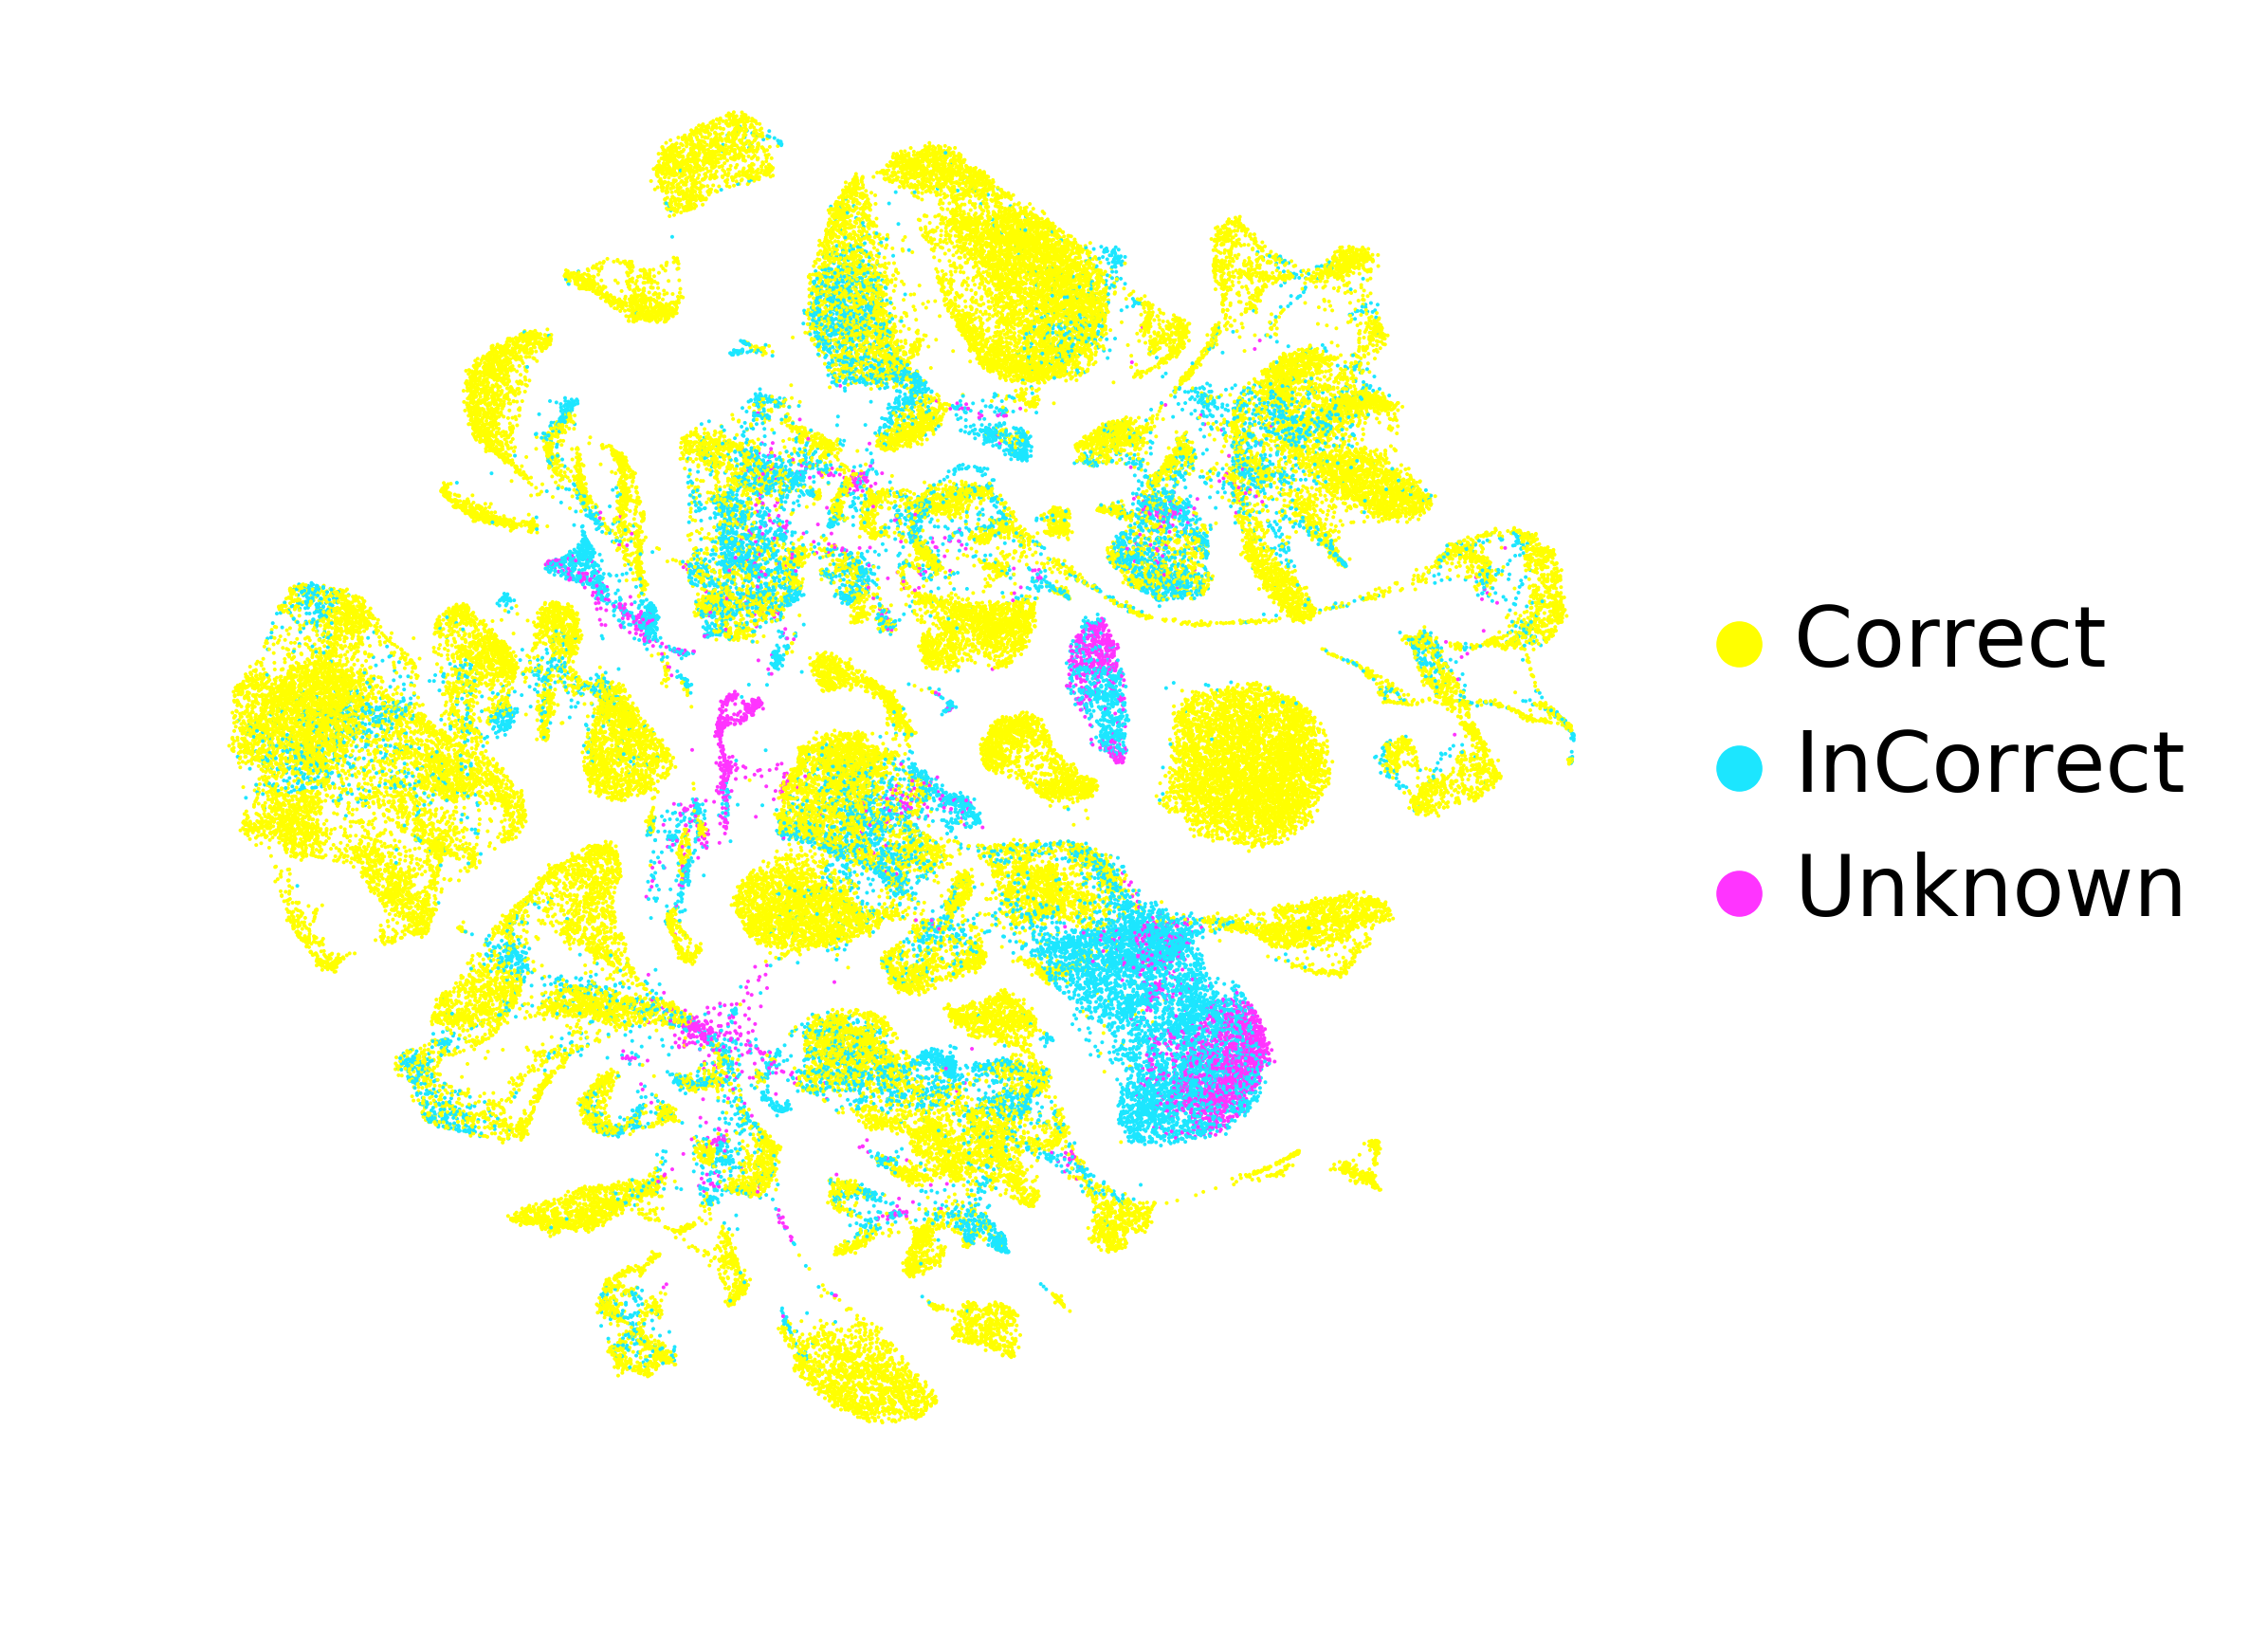

In [ ]:
sc.pl.umap(latent_adata_out_of_sample, color='labels_evaluation_w_unknown', save='_labels_eval_muris_with_unknown.pdf',
           frameon=False, title='', show=True, palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata_out_of_sample, color='uncertainty_w_unknown', save='_uncertainty_muris_with_unknown.pdf',
           frameon=False, title='', show=True)
sc.pl.umap(latent_adata_out_of_sample, color='tissue', save='_tissue_muris.pdf',
           frameon=False, title='', show=True, legend_loc='on data', 
           legend_fontsize=5, legend_fontweight='normal')
sc.pl.violin(latent_adata_out_of_sample, groupby='labels_evaluation_w_unknown', keys='uncertainty_w_unknown', 
             rotation=45, jitter=False, save='_uncertainty_w_unknown.pdf')

### 3.2 Without Unknown prediction

In [51]:
pred_labels, uncertainties = surgeon.utils.weighted_knn(latent_adata_for_training, 
                                                        latent_adata_out_of_sample, 
                                                        cell_type_key, 
                                                        n_neighbors=n_neighbors, 
                                                        threshold=threshold, 
                                                        pred_unknown=False, 
                                                        return_uncertainty=True,
                                                       )

Weighted KNN with n_neighbors = 80 and threshold = 0.3 ... finished!


In [52]:
true_labels = np.array(latent_adata_out_of_sample.obs[cell_type_key].values).reshape(-1, 1)

labels_eval = pred_labels == true_labels
labels_eval = labels_eval.astype(object)

labels_eval[labels_eval == True] = 'Correct'
labels_eval[labels_eval == False] = 'InCorrect'

latent_adata_out_of_sample.obs['labels_evaluation_wo_unknown'] = pd.Categorical(labels_eval.reshape(-1, ))
latent_adata_out_of_sample.obs['uncertainty_wo_unknown'] = uncertainties

In [ ]:
sc.pl.umap(latent_adata_out_of_sample, color='labels_evaluation_wo_unknown', save='_labels_eval_muris_without_unknown.pdf',
           frameon=False, title='', show=True, palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(latent_adata_out_of_sample, color='uncertainty_wo_unknown', save='_uncertainty_muris_without_unknown.pdf',
           frameon=False, title='', show=True)
sc.pl.umap(latent_adata_out_of_sample, color='tissue', save='_tissue_muris.pdf',
           frameon=False, title='', show=True, legend_loc='on data', 
           legend_fontsize=5, legend_fontweight='normal')
sc.pl.violin(latent_adata_out_of_sample, groupby='labels_evaluation_wo_unknown', keys='uncertainty_wo_unknown', 
             rotation=45, jitter=False, save='_uncertainty_wo_unknown.pdf')